In [1]:
import numpy as np
import pdb
from scipy import integrate
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import t as t_dist
from scipy.optimize import minimize

def logistic_DE(t,y,q):
    
    '''
    logistic DE, dC/dt = rC(1 - C/K)

    inputs:
        t:    time
        y:    current solution [u]
        q:    parameters [r, K]
        
    outputs:
        dydt: derivative value
    '''
    r,K = q
    
    dydt = r*y[0]*(1.0-y[0]/K)
    
    return dydt

def logistic_sensitivity_DE(t,y,q):
    
    '''
    Sensitivity DE for logistic DE, dC/dt = rC(1 - C/K)

    inputs:
        t:    time
        y:    current solution [u, chi_r, chi_K]
        q:    parameters [r, K]
        
    outputs:
        dydt: derivative value
    '''
    
    dydt = np.zeros(3,)
    r,K = q
    
    dydt[0] = r*y[0]*(1.0-y[0]/K)
    dydt[1] = y[0] + r*y[1] - (1.0/K)*y[0]**2-(2.0*r/K)*y[0]*y[1]
    dydt[2] = r*y[2] + (r/K**2)*y[0]**2      -(2.0*r/K)*y[0]*y[2]
    
    return dydt
    

def ODE_sim(q,RHS,t,IC):
    
    '''
    simulate ODE dy/dt = f(t,y)

    inputs:
        q:    parameters
        RHS:  function for f(t,y)
        t:    time
        IC:   Initial condition, should be size (n,)

        
    outputs:
        y:    solution y(t)
    '''

    #grids for numerical integration
    t_sim = np.linspace(t[0],t[-1],10000)

    #Initial condition
    y0 = IC
        
    #indices for integration steps to write to file for
    for tp in t:
        tp_ind = np.abs(tp-t_sim).argmin()
        if tp == t[0]:
            t_sim_write_ind = np.array(tp_ind)
        else:
            t_sim_write_ind = np.hstack((t_sim_write_ind,tp_ind))

    #make RHS a function of t,y
    def RHS_ty(t,y):
        return RHS(t,y,q)
            
    #initialize solution
    y = np.zeros((len(y0),len(t)))   
    y[:,0] = IC
    write_count = 1

    #integrate
    r = integrate.ode(RHS_ty).set_integrator("dopri5")  # choice of method
    r.set_initial_value(y0, t[0])   # initial values
    for i in range(1, t_sim.size):
        #write to y during write indices
        if np.any(i==t_sim_write_ind):
            y[:,write_count] = r.integrate(t_sim[i])
            write_count+=1
        else:
            #otherwise just integrate
            r.integrate(t_sim[i]) # get one more value, add it to the array
        if not r.successful():
            print("integration failed for parameter ")
            print(q)
            return 1e6*np.ones(y.shape)

    return y.T

## Sensitivities

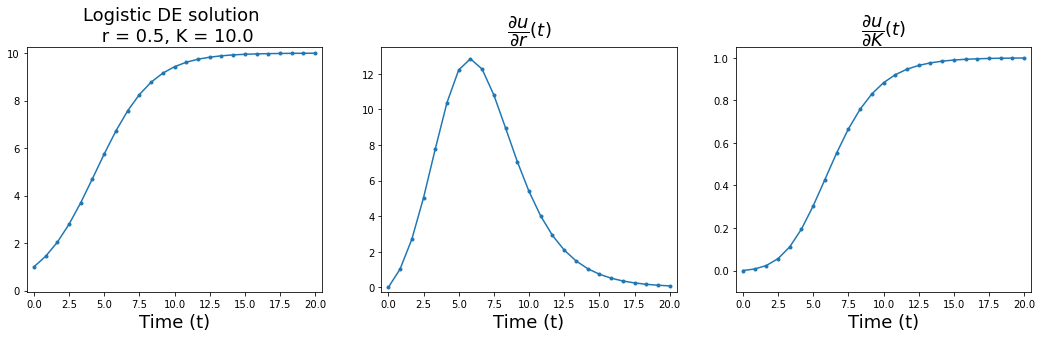

In [2]:
RHS = logistic_sensitivity_DE
n = 25
t = np.linspace(0,20,n)
IC = np.array([1.0,0,0])

r0 = 0.5
K0 = 10.0
q = np.array([r0,K0])

U = ODE_sim(q,RHS,t,IC)

fig = plt.figure(figsize=(18,4.5))

fontsize=18

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.plot(t, U[:,0],".-")
ax2.plot(t, U[:,1],".-")
ax3.plot(t, U[:,2],".-")

axs = [ax1,ax2,ax3]
ylims = [[-0.05,K0+0.25],[-.25,13.5],[-.1,1.05]]
titles = [f"Logistic DE solution \n r = {r0}, K = {K0}","$\dfrac{\partial u}{\partial r}(t)$","$\dfrac{\partial u}{\partial K}(t)$",]
for i,ax in enumerate(axs):
    ax.set_xlim([-.5,20.5])
    ax.set_ylim(ylims[i])
    ax.set_xlabel("Time (t)",fontsize=fontsize)
    ax.set_title(titles[i],fontsize=fontsize)
plt.savefig(f"sensitivities_r_{r0}_K_{K0}.pdf",format="pdf")    

## Data generation 

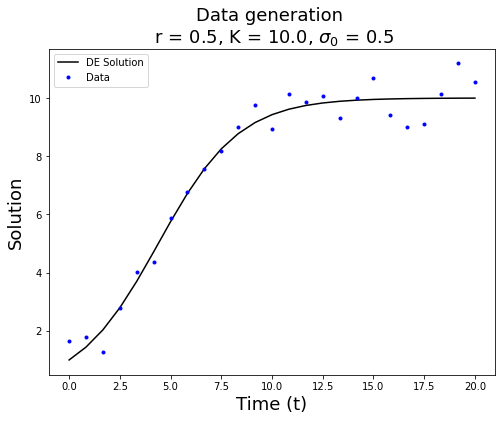

In [19]:
np.random.seed(seed=10)

RHS = logistic_DE
q0 = np.array([r0,K0])
p = len(q0)
IC = np.array([1.0])

sigma0 = 0.5

#simulate ODE at true parameter value
u0 = ODE_sim(q0,RHS,t,IC)
#noise
eps = norm.rvs(size=u0.shape,scale=sigma0)
#OLS statistical model
data = u0 + eps

plt.figure(figsize=(8,6))
plt.plot(t,u0,"k-",label="DE Solution")
plt.plot(t,data,"b.",label="Data")

plt.xlabel("Time (t)" ,fontsize=fontsize)
plt.ylabel("Solution" ,fontsize=fontsize)
plt.title(f"Data generation \n r = {r0}, K = {K0}, $\sigma_0$ = {sigma0}" ,fontsize=fontsize)
plt.legend()

plt.savefig(f"Data_generation_r_{r0}_K_{K0}_sigma_{sigma0}.pdf",format="pdf")

## Estimate true params

In [20]:
def cost_function(q, data):
    
    '''
    computes cost function for input parameter

    inputs:
        q:    parameters [r, K]
        data: noisy data
        
    outputs:
        cost_function: cost function evaluation at this value
    '''
    
    IC = np.array([1.0])
    u_sim = ODE_sim(q,logistic_DE,t,IC)
    res = data - u_sim
    cost_function = np.sum(res**2)
    
    return cost_function

In [21]:
#both parameters are positive
bnds = ((0, None), (0, None))
#initial guess
x0 = np.array([5,5])

res = minimize(cost_function, x0, method='SLSQP', tol=1e-6, bounds=bnds, args = (data))
q_hat = res.x

RHS = logistic_DE
u_sampler = ODE_sim(q_hat,RHS,t,np.array([1.0]))

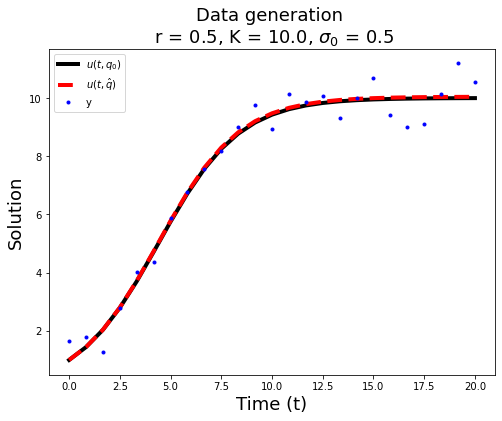

In [22]:
plt.figure(figsize=(8,6))
plt.plot(t,u0,"k-",label="$u(t,q_0)$",linewidth=4)
plt.plot(t,u_sampler,"r--",label="$u(t,\hat{q})$",linewidth=4)
plt.plot(t,data,"b.",label = "y")

plt.xlabel("Time (t)" ,fontsize=fontsize)
plt.ylabel("Solution" ,fontsize=fontsize)
plt.title(f"Data generation \n r = {r0}, K = {K0}, $\sigma_0$ = {sigma0}" ,fontsize=fontsize)
plt.legend()

plt.legend()

plt.savefig(f"Data_generation_with_estimate_r_{r0}_K_{K0}_sigma_{sigma0}.pdf",format="pdf")

## Variance estimation

0.5523157560199053


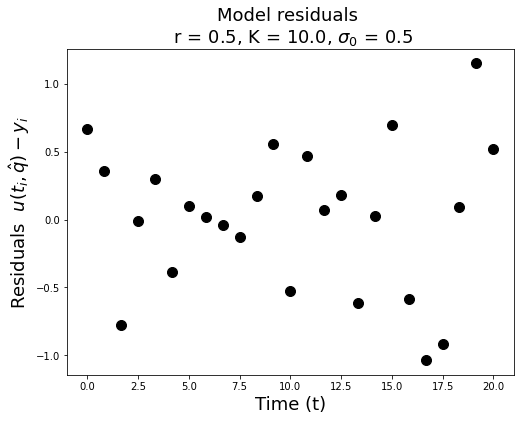

In [23]:
u_estimate = ODE_sim(q_hat,RHS,t,np.array([1.0]))
res = (data - u_estimate)
sigma_hat = np.squeeze(np.sqrt(1/(n-p)*np.matmul(res.T,res)))
print(sigma_hat)

plt.figure(figsize=(8,6))
plt.plot(t,res,"k.",markersize=20)

plt.xlabel("Time (t)" ,fontsize=fontsize)
plt.ylabel("Residuals  $u(t_i,\hat{q}) - y_i$" ,fontsize=fontsize)
plt.title(f"Model residuals \n r = {r0}, K = {K0}, $\sigma_0$ = {sigma0}" ,fontsize=fontsize)

plt.savefig(f"Model_residuals_r_{r0}_K_{K0}_sigma_{sigma0}.pdf",format="pdf")

## Distribution of q

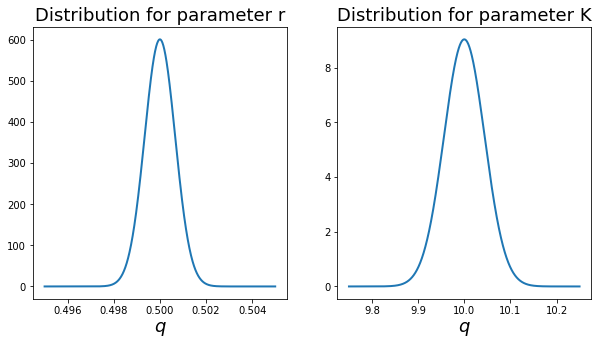

In [36]:
### Sensitivities
RHS = logistic_sensitivity_DE
IC = np.array([1.0,0,0])
#confidence interval significance level
alpha = 0.05

U = ODE_sim(q,RHS,t,IC)

#Extract du/dr and du/dK
Chi = U[:,1:]

#create variance matrix
ChiTChi = np.matmul(Chi.T,Chi)
ChiTChi_inv = np.linalg.inv(ChiTChi)
#create delta terms
delta = np.diag(ChiTChi_inv)

###Plot the distributions
x_axis_r = np.arange(q[0]-0.01*sigma0, q[0]+0.01*sigma0, 0.00001)
x_axis_K = np.arange(q[1]-.5*sigma0, q[1]+.5*sigma0, 0.0001)

fig = plt.figure(figsize=(10,5))    

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax1.plot(x_axis_r, norm.pdf(x_axis_r, q[0], sigma0*delta[0]),linewidth=2)
ax2.plot(x_axis_K, norm.pdf(x_axis_K, q[1], sigma0*delta[1]),linewidth=2)

axs = [ax1,ax2]
titles = ["Distribution for parameter r","Distribution for parameter K"]

for ax, title in zip(axs,titles):
    ax.set_title(title,fontsize=fontsize)
    ax.set_xlabel("$q$",fontsize=fontsize)
    
plt.savefig(f"Distn_r_{r0}_K_{K0}_sigma_{sigma0}.pdf",format="pdf")    

## Confidence interval construction

In [24]:
RHS = logistic_sensitivity_DE
IC = np.array([1.0,0,0])
#confidence interval significance level
alpha = 0.05

U = ODE_sim(q_hat,RHS,t,IC)

#Extract du/dr and du/dK
Chi = U[:,1:]

ChiTChi = np.matmul(Chi.T,Chi)
ChiTChi_inv = np.linalg.inv(ChiTChi)

delta = np.diag(ChiTChi_inv)

print(sigma_hat*ChiTChi_inv)
print("")
t_alpha = t_dist.ppf(q=1 - alpha/2.0, df=n-p)

radius = sigma_hat*np.sqrt(delta)*t_alpha

LB = q_hat - radius
UB = q_hat + radius

bounds = np.hstack([LB[:,None], UB[:,None]])

print(q0)
print(bounds)


[[ 0.00072828 -0.00283092]
 [-0.00283092  0.04864466]]

[ 0.5 10. ]
[[ 0.45991092  0.54288836]
 [ 9.70527235 10.38342884]]


In [34]:
true_param_in_CI = True
for i, qq in enumerate(q0):
    if qq < bounds[i,0] or qq > bounds[i,1]:
        true_param_in_CI == False
print(true_param_in_CI)    

True


In [ ]:
def data_generation(q0,sigma_0,seed=1):

    np.random.seed(seed=seed)

    RHS = logistic_DE
    p = len(q0)
    IC = np.array([1.0])

    u0 = ODE_sim(q0,RHS,t,IC)
    eps = norm.rvs(size=u0.shape,scale=sigma0)
    #OLS model
    data = u0 + eps
    
    return data


def estimate_params(data):
    
    #both parameters are positive
    bnds = ((0, None), (0, None))
    #initial guess
    x0 = np.array([5,5])

    res = minimize(cost_function, x0, method='SLSQP', tol=1e-6, bounds=bnds, args = (data))
    q_hat = res.x

    return q_hat

def variance_estimation(data,q_hat):
    
    RHS = logistic_DE
    u_sampler = ODE_sim(q_hat,RHS,t,np.array([1.0]))
    
    res = (data - u_sampler)
    sigma_hat = np.squeeze(np.sqrt(1/(n-p)*np.matmul(res.T,res)))
    
    return sigma_hat

def create_CI(q_hat,alpha=0.5):
    
    RHS = logistic_sensitivity_DE
    IC = np.array([1.0,0,0])

    U = ODE_sim(q_hat,RHS,t,IC)

    #Extract du/dr and du/dK
    Chi = U[:,1:]

    ChiTChi = np.matmul(Chi.T,Chi)
    ChiTChi_inv = np.linalg.inv(ChiTChi)
    
    t_alpha = t_dist.ppf(q=1 - alpha/2.0, df=n-p)

    radius = sigma_hat*np.sqrt(delta)*t_alpha

    LB = q_hat - radius
    UB = q_hat + radius

    bounds = np.hstack([LB[:,None], UB[:,None]])
    
    return bounds


def check_true_param_in_CI(q0, bounds):
    
    true_param_in_CI = True
    for i, qq in enumerate(q0):
        if qq < bounds[i,0] or qq > bounds[i,1]:
            true_param_in_CI == False
    
    return true_param_in_CI




In [ ]:
sigma0 = 0.5
q0 = np.array([0.5,10.0])

q_hats = []

success = 0
for i in np.arange(10):
    print(f"Dataset {i+1}")
    y = data_generation(q0,sigma0,seed=i)
    
    q_hat = estimate_params(y)
    
    sigma_hat = variance_estimation(y,q_hat)
    
    CI = create_CI(q_hat,alpha=0.5)
    
    if check_true_param_in_CI(q0,CI):
        success+=1
        
    q_hats.append(q_hat)
    

In [ ]:
q_hats = np.array(q_hats)

plt.hist(q_hats[:,0])